# Topic Modeling using RoBerta

Use Roberta model from hugging face to create embeddings for clustering  / Topic modeling

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

from itables import show

import folium
import geopandas

from sklearn import decomposition, preprocessing
from sklearn.metrics import pairwise_distances
from sklearn.manifold import MDS, TSNE
from sklearn.ensemble import IsolationForest

from scipy.cluster import hierarchy

from sentence_transformers import SentenceTransformer

In [2]:

model_roberta = SentenceTransformer('sentence-transformers/all-roberta-large-v1')
#'all-roberta-large-v1'

In [ ]:
# df_clean_2001_pick = pd.read_pickle('..\data\df_clean_2001_clustered_pick.pkl.gz', compression='gzip')

### Inspecting the cleaned emails shows some long emails. Roberta is more suited to handle bigger tokens

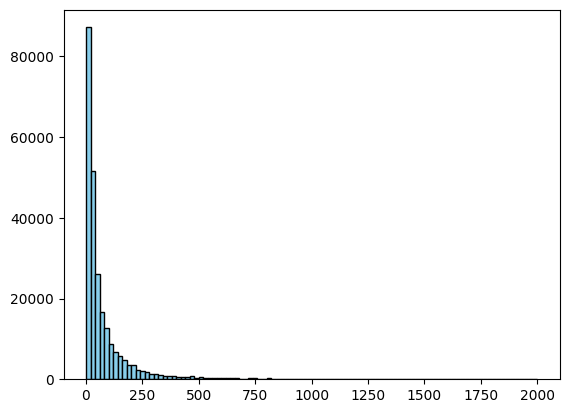

In [29]:
df_clean_2001_pick.head(2)

bod_1 = df_clean_2001_pick.cleaned_email_body.to_list()

# Split each string by whitespace and calculate the length of the resulting list
word_counts = df_clean_2001_pick.cleaned_email_body.str.split().str.len()

# Create the histogram
mask = word_counts < 2000


plt.hist(word_counts[mask], bins=100, color='skyblue', edgecolor='black')

# Show the plot
plt.show()

In [30]:
# emb_bod = model_roberta.encode(bod_1) # roberta large takes too long
emb_bod = model_roberta.encode(bod_1)
emb_bod[:5]

array([[-0.0138427 ,  0.00841489,  0.02853232, ...,  0.06726661,
         0.00924207, -0.01508029],
       [ 0.0354958 ,  0.01536476,  0.01352976, ..., -0.01073769,
        -0.00060126, -0.02119869],
       [ 0.00893574, -0.04460603, -0.02530432, ...,  0.06321701,
         0.00224678, -0.03619694],
       [ 0.0001451 ,  0.01376917, -0.03608034, ...,  0.01936221,
         0.01717136, -0.044983  ],
       [-0.00385308, -0.05268845,  0.03604534, ...,  0.01055537,
         0.02912994, -0.02199491]], dtype=float32)

In [36]:
len(emb_bod[0])
# len(emb_bod)

1024

In [37]:
len(df_clean_2001_pick['embedding'].iloc[0])

384

In [32]:
df_clean_2001_pick['embedding_roberta']  = emb_bod.tolist()
df_clean_2001_pick.head(2)

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body,cleaned_email_body,embedding,possible_accounting,umap_hdbscan_clusters,umap_hdbscan_clusters2,kmeans_clusters,reduced_embeddings,embedding_roberta
278,"Yahoo! Newsletter, May 2001",2001-05-14,<12657912.1075855693014.JavaMail.evans@thyme>,yahoo-delivers@yahoo-inc.com,Allen-P,all_documents,,[IMAGE]\nYahoo! sent this email to you because...,[IMAGE] Yahoo! sent this email to you because ...,"[-0.010776377283036709, -0.029210280627012253,...",0.269633,21027,9461,348,"[5.331789970397949, 4.658625602722168, 6.52953...","[-0.01384270191192627, 0.008414888754487038, 0..."
279,Texas puts reliability rules through paces,2001-05-14,<6437131.1075855693092.JavaMail.evans@thyme>,ei_editor@ftenergy.com,Allen-P,all_documents,,Dear Energy Insight Subscribers.?If you canno...,Dear Energy Insight Subscribers.?If you cannot...,"[-0.053877584636211395, -0.010433554649353027,...",0.162866,7352,3258,306,"[4.739575386047363, 3.012366771697998, 7.58288...","[0.03549579530954361, 0.015364758670330048, 0...."


In [ ]:
# df_clean_2001_pick.to_pickle('..\data\df_clean_2001_clustered_pick.pkl.gz', compression='gzip')

## Clustering

### Dimension reduction from 1024 vector size to 15 (just trying 15)

In [ ]:
from sklearn.cluster import KMeans

import umap

loaded_vector = np.array(df_clean_2001_pick['embedding_roberta'].to_list(),dtype=np.float32)

# Initialize and fit the UMAP model
# `n_components` is the target dimensionality
# `n_neighbors` is a key parameter for UMAP. A higher value leads to a more global view of the data.
umap_model = umap.UMAP(
    n_neighbors=30, 
    n_components=15, 
    metric='cosine', 
    min_dist=0.0,
    random_state=42
)

reduced_embeddings = umap_model.fit_transform(loaded_vector)

reduced_embeddings.shape

In [7]:
df_clean_2001_pick['embedding_roberta_reduced']  = reduced_embeddings.tolist()
df_clean_2001_pick.head(2)

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body,cleaned_email_body,embedding,possible_accounting,umap_hdbscan_clusters,umap_hdbscan_clusters2,kmeans_clusters,reduced_embeddings,embedding_roberta,embedding_roberta_reduced
278,"Yahoo! Newsletter, May 2001",2001-05-14,<12657912.1075855693014.JavaMail.evans@thyme>,yahoo-delivers@yahoo-inc.com,Allen-P,all_documents,,[IMAGE]\nYahoo! sent this email to you because...,[IMAGE] Yahoo! sent this email to you because ...,"[-0.010776377283036709, -0.029210280627012253,...",0.269633,21027,9461,348,"[5.331789970397949, 4.658625602722168, 6.52953...","[-0.01384270191192627, 0.008414888754487038, 0...","[3.196415662765503, 6.6560587882995605, 6.1493..."
279,Texas puts reliability rules through paces,2001-05-14,<6437131.1075855693092.JavaMail.evans@thyme>,ei_editor@ftenergy.com,Allen-P,all_documents,,Dear Energy Insight Subscribers.?If you canno...,Dear Energy Insight Subscribers.?If you cannot...,"[-0.053877584636211395, -0.010433554649353027,...",0.162866,7352,3258,306,"[4.739575386047363, 3.012366771697998, 7.58288...","[0.03549579530954361, 0.015364758670330048, 0....","[7.292938709259033, 4.749783992767334, 4.90643..."


In [8]:
df_clean_2001_pick.drop(columns=['embedding','possible_accounting','umap_hdbscan_clusters','umap_hdbscan_clusters2','kmeans_clusters','reduced_embeddings'], inplace=True)

df_clean_2001_pick.to_pickle('..\data\df_clean_2001_roberta_pick.pkl.gz', compression='gzip')

df_clean_2001_pick.head(2)

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body,cleaned_email_body,embedding_roberta,embedding_roberta_reduced
278,"Yahoo! Newsletter, May 2001",2001-05-14,<12657912.1075855693014.JavaMail.evans@thyme>,yahoo-delivers@yahoo-inc.com,Allen-P,all_documents,,[IMAGE]\nYahoo! sent this email to you because...,[IMAGE] Yahoo! sent this email to you because ...,"[-0.01384270191192627, 0.008414888754487038, 0...","[3.196415662765503, 6.6560587882995605, 6.1493..."
279,Texas puts reliability rules through paces,2001-05-14,<6437131.1075855693092.JavaMail.evans@thyme>,ei_editor@ftenergy.com,Allen-P,all_documents,,Dear Energy Insight Subscribers.?If you canno...,Dear Energy Insight Subscribers.?If you cannot...,"[0.03549579530954361, 0.015364758670330048, 0....","[7.292938709259033, 4.749783992767334, 4.90643..."


### Cluster on reduced robera embeddings

In [ ]:
df_clean_2001_pick = pd.read_pickle('..\data\df_clean_2001_roberta_pick.pkl.gz', compression='gzip')

df_clean_2001_pick.head(2)

In [69]:
df_clean_2001_pick.head(2)

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body,cleaned_email_body,embedding_roberta,embedding_roberta_reduced,hdbscan_clusters_roberta,hdbscan_clusters_roberta_prob,reduced_labels_dbscan_cut,reduced_labels_scipy_cut,possible_accounting,possible_hate_anger
278,"Yahoo! Newsletter, May 2001",2001-05-14,<12657912.1075855693014.JavaMail.evans@thyme>,yahoo-delivers@yahoo-inc.com,Allen-P,all_documents,,[IMAGE]\nYahoo! sent this email to you because...,[IMAGE] Yahoo! sent this email to you because ...,"[-0.01384270191192627, 0.008414888754487038, 0...","[3.196415662765503, 6.6560587882995605, 6.1493...",6276,1.0,1742,497,0.102435,0.182009
279,Texas puts reliability rules through paces,2001-05-14,<6437131.1075855693092.JavaMail.evans@thyme>,ei_editor@ftenergy.com,Allen-P,all_documents,,Dear Energy Insight Subscribers.?If you canno...,Dear Energy Insight Subscribers.?If you cannot...,"[0.03549579530954361, 0.015364758670330048, 0....","[7.292938709259033, 4.749783992767334, 4.90643...",-1,0.0,1742,497,0.212221,0.164912


### Dedupe by cleaned_email_body
1. To avoid getting cluster formation from the same email content
2. Dedupe should have been done before roberta encoding to save on process time

In [91]:

# Deduplicate based on the 'ID' column, keeping the first occurrence
df_clean_2001_pick_dedupe = df_clean_2001_pick[['cleaned_email_body','embedding_roberta','embedding_roberta_reduced']].drop_duplicates(subset=['cleaned_email_body'], keep='first')
df_clean_2001_pick_dedupe.reset_index(drop=True, inplace=True)

In [94]:
# df_clean_2001_pick_dedupe

# Find matching rows based on 'ID'
# matching_rows = pd.merge(df_clean_2001_pick, df_clean_2001_pick_dedupe, on='cleaned_email_body', how='inner')
print(matching_rows.shape)
print(df_clean_2001_pick.shape)

(250455, 19)
(250455, 17)


In [95]:
# len(df_clean_2001_pick.embedding_roberta_reduced.iloc[0])

import hdbscan


# reduced_embeddings=df_clean_2001_pick.embedding_roberta_reduced.to_list()
reduced_embeddings=df_clean_2001_pick_dedupe.embedding_roberta_reduced.to_list()

# Initialize and fit the HDBSCAN model
# `min_cluster_size` is a key parameter that controls the minimum number of documents in a cluster
hdbscan_model = hdbscan.HDBSCAN(
    min_cluster_size=5, 
    metric='euclidean', 
    gen_min_span_tree=True
)

clusterer = hdbscan_model.fit(reduced_embeddings)

cluster_assignment = clusterer.labels_
cluster_probabilities = clusterer.probabilities_



# cluster_assignment[:10]
df_clean_2001_pick_dedupe['hdbscan_clusters_roberta'] = cluster_assignment
df_clean_2001_pick_dedupe['hdbscan_clusters_roberta_prob'] = cluster_probabilities

df_clean_2001_pick_dedupe.head(2)

c:\Users\User\OneDrive\文件\PythonScripts\myenv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\User\OneDrive\文件\PythonScripts\myenv\lib\site-packages\sklearn\utils\deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


,cleaned_email_body,embedding_roberta,embedding_roberta_reduced,hdbscan_clusters_roberta,hdbscan_clusters_roberta_prob
0,[IMAGE] Yahoo! sent this email to you because ...,"[-0.01384270191192627, 0.008414888754487038, 0...","[3.196415662765503, 6.6560587882995605, 6.1493...",2449,1.000000
1,Dear Energy Insight Subscribers.?If you cannot...,"[0.03549579530954361, 0.015364758670330048, 0....","[7.292938709259033, 4.749783992767334, 4.90643...",2298,0.541348


In [99]:
print(f"total clusters uncut is {len(df_clean_2001_pick_dedupe.hdbscan_clusters_roberta.unique())}")

total clusters uncut is 4749


### Cutting tree to something manageable

1. Cut at a fixed distance (or lambda) value: You can get a flat clustering equivalent to running DBSCAN* (DBSCAN without border points) at a specific density level. This is done using the dbscan_clustering() method on the fitted object.

2. Cut for a fixed number of clusters: While not a native feature of HDBSCAN itself (which doesn't require or assume a number of clusters), you can use the scipy.cluster.hierarchy library to cut the HDBSCAN tree to get a specific number of clusters. 

In [100]:

from scipy.cluster.hierarchy import fcluster


# Cut at a specific density level (lambda or 1/distance)
# The `dbscan_clustering` method extracts a DBSCAN*-like clustering from the hierarchy
epsilon_cut = 0.6
dbscan_labels = clusterer.dbscan_clustering(cut_distance=epsilon_cut)
print(f"\nNumber of clusters from DBSCAN*-like cut at epsilon={epsilon_cut}: {len(np.unique(dbscan_labels[dbscan_labels != -1]))}")


epsilon_cut2 = 0.8
dbscan_labels_80 = clusterer.dbscan_clustering(cut_distance=epsilon_cut2)
print(f"\nNumber of clusters from DBSCAN*-like cut at epsilon={epsilon_cut2}: {len(np.unique(dbscan_labels_80[dbscan_labels_80 != -1]))}")

# Cut to get a fixed number of clusters using SciPy
# Convert HDBSCAN's hierarchy to a format compatible with SciPy
single_linkage_matrix = clusterer.single_linkage_tree_.to_numpy()
n_clusters_target = 500
scipy_labels = fcluster(single_linkage_matrix, t=n_clusters_target, criterion='maxclust')

# SciPy labels are 1-indexed, we convert to match hdbscan's 0-indexed clusters
# Subtract 1 from all positive labels to match HDBSCAN's convention
scipy_labels[scipy_labels != 0] -= 1
print(f"\nNumber of clusters from SciPy cut to get {n_clusters_target} clusters: {len(np.unique(scipy_labels))}")



Number of clusters from DBSCAN*-like cut at epsilon=0.6: 791

Number of clusters from DBSCAN*-like cut at epsilon=0.8: 689

Number of clusters from SciPy cut to get 500 clusters: 500


### Create a dataframe for unique cluster assignment for each unique email

In [101]:
# cluster_assignment[:10]
df_clean_2001_pick_dedupe['reduced_labels_dbscan_cut'] = dbscan_labels
df_clean_2001_pick_dedupe['reduced_labels_scipy_cut'] = scipy_labels

df_clean_2001_pick_dedupe.head(2)

,cleaned_email_body,embedding_roberta,embedding_roberta_reduced,hdbscan_clusters_roberta,hdbscan_clusters_roberta_prob,reduced_labels_dbscan_cut,reduced_labels_scipy_cut
0,[IMAGE] Yahoo! sent this email to you because ...,"[-0.01384270191192627, 0.008414888754487038, 0...","[3.196415662765503, 6.6560587882995605, 6.1493...",2449,1.000000,259,56
1,Dear Energy Insight Subscribers.?If you cannot...,"[0.03549579530954361, 0.015364758670330048, 0....","[7.292938709259033, 4.749783992767334, 4.90643...",2298,0.541348,259,56


In [11]:
print(df_clean_2001_pick['hdbscan_clusters_roberta'].unique().shape)

(12914,)


### Clean df_clean_2001_pick and re-assign clusters based on deduplicated version

In [106]:
# df_clean_2001_pick.drop(columns=['embedding_roberta','embedding_roberta_reduced','hdbscan_clusters_roberta'\
#                                  ,'reduced_labels_dbscan_cut','reduced_labels_scipy_cut','hdbscan_clusters_roberta_prob'], inplace=True)


df_clean_2001_pick=df_clean_2001_pick.merge(df_clean_2001_pick_dedupe, on='cleaned_email_body', how='left', validate='many_to_one', indicator=True,suffixes=('', '_dedupe'))        
df_clean_2001_pick

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body,cleaned_email_body,possible_accounting,possible_hate_anger,embedding_roberta,embedding_roberta_reduced,hdbscan_clusters_roberta,hdbscan_clusters_roberta_prob,reduced_labels_dbscan_cut,reduced_labels_scipy_cut,_merge
0,"Yahoo! Newsletter, May 2001",2001-05-14,<12657912.1075855693014.JavaMail.evans@thyme>,yahoo-delivers@yahoo-inc.com,Allen-P,all_documents,,[IMAGE]\nYahoo! sent this email to you because...,[IMAGE] Yahoo! sent this email to you because ...,0.102435,0.182009,"[-0.01384270191192627, 0.008414888754487038, 0...","[3.196415662765503, 6.6560587882995605, 6.1493...",2449,1.000000,259,56,both
1,Texas puts reliability rules through paces,2001-05-14,<6437131.1075855693092.JavaMail.evans@thyme>,ei_editor@ftenergy.com,Allen-P,all_documents,,Dear Energy Insight Subscribers.?If you canno...,Dear Energy Insight Subscribers.?If you cannot...,0.212221,0.164912,"[0.03549579530954361, 0.015364758670330048, 0....","[7.292938709259033, 4.749783992767334, 4.90643...",2298,0.541348,259,56,both
2,Mid-Year 2001 Performance Feedback,2001-05-14,<9385129.1075855693206.JavaMail.evans@thyme>,perfmgmt@enron.com,Allen-P,all_documents,,"ALLEN, PHILLIP K,\n?\nYou have been selected t...","ALLEN, PHILLIP K, ? You have been selected to ...",0.332117,0.306158,"[0.008935743011534214, -0.044606033712625504, ...","[1.1482068300247192, 8.128674507141113, 6.9614...",353,1.000000,486,56,both
3,"Freidman, Billings Initiates Coverage of PMCS",2001-05-14,<30046957.1075855693228.JavaMail.evans@thyme>,webmaster@earnings.com,Allen-P,all_documents,,"If you cannot read this email, please click he...","If you cannot read this email, please click he...",0.302259,0.340298,"[0.00014509704487863928, 0.013769167475402355,...","[5.773691654205322, 5.747415542602539, 5.74301...",3793,0.556631,259,56,both
4,Pre-selected NextCard Visa! As low as 2.99%,2001-05-14,<5010711.1075855693251.JavaMail.evans@thyme>,announce@inbox.nytimes.com,Allen-P,all_documents,,"Dear NYTimes.com member,\n\nYour registration ...","Dear NYTimes.com member, Your registration to ...",0.117268,0.187203,"[-0.0038530821911990643, -0.05268844589591026,...","[3.4631612300872803, 7.059370040893555, 6.3602...",1858,0.190725,259,56,both
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250450,RE: Clearing discussion,2001-05-25,<18240957.1075845411960.JavaMail.evans@thyme>,greg.piper@enron.com,ZIPPER-A,deleted_items,,I heard Whalley was neutral to the London Clea...,I heard Whalley was neutral to the London Clea...,0.192449,0.099233,"[-0.021836217492818832, -0.046125032007694244,...","[5.857641220092773, 4.254520416259766, 4.41178...",3988,0.921149,259,56,both
250451,FW: Recommended Offer by ICE for IPE Holdings,2001-05-24,<22475265.1075845411983.JavaMail.evans@thyme>,greg.piper@enron.com,ZIPPER-A,deleted_items,,Does our less than 1% get us more relavent inf...,Does our less than 1% get us more relavent inf...,0.176361,0.207087,"[0.002236237283796072, -0.003095505526289344, ...","[5.4614481925964355, 4.624105453491211, 5.2555...",-1,0.000000,259,56,both
250452,,2001-05-24,<19544834.1075845412008.JavaMail.evans@thyme>,greg.piper@enron.com,ZIPPER-A,deleted_items,,"A peace offering. \n\nYour boy, former Democr...","A peace offering. Your boy, former Democratic ...",0.166797,0.188450,"[-0.020976148545742035, 0.0326056070625782, 0....","[5.248353958129883, 4.260470867156982, 5.35838...",-1,0.000000,259,56,both
250453,RE: Recommended Offer by ICE for IPE Holdings,2001-05-24,<25702685.1075845412032.JavaMail.evans@thyme>,greg.piper@enron.com,ZIPPER-A,deleted_items,,"OK, so how much do we own and what rights will...","OK, so how much do we own and what rights will...",0.249506,0.256936,"[-0.05726884678006172, 0.003949659410864115, 0...","[5.870572566986084, 3.680464744567871, 4.45532...",-1,0.000000,259,56,both


In [109]:
df_clean_2001_pick.shape
df_clean_2001_pick.drop("_merge", axis=1, inplace=True)
df_clean_2001_pick.columns

Index(['subject', 'date_short', 'message_id', 'from_addr', 'person_box',
       'sub_mailbox', 'sub_mailbox2', 'email_body', 'cleaned_email_body',
       'possible_accounting', 'possible_hate_anger', 'embedding_roberta',
       'embedding_roberta_reduced', 'hdbscan_clusters_roberta',
       'hdbscan_clusters_roberta_prob', 'reduced_labels_dbscan_cut',
       'reduced_labels_scipy_cut'],
      dtype='object')

In [110]:
df_clean_2001_pick.to_pickle('..\data\df_clean_2001_roberta_pick.pkl.gz', compression='gzip')

df_clean_2001_pick.head(2)

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body,cleaned_email_body,possible_accounting,possible_hate_anger,embedding_roberta,embedding_roberta_reduced,hdbscan_clusters_roberta,hdbscan_clusters_roberta_prob,reduced_labels_dbscan_cut,reduced_labels_scipy_cut
0,"Yahoo! Newsletter, May 2001",2001-05-14,<12657912.1075855693014.JavaMail.evans@thyme>,yahoo-delivers@yahoo-inc.com,Allen-P,all_documents,,[IMAGE]\nYahoo! sent this email to you because...,[IMAGE] Yahoo! sent this email to you because ...,0.102435,0.182009,"[-0.01384270191192627, 0.008414888754487038, 0...","[3.196415662765503, 6.6560587882995605, 6.1493...",2449,1.000000,259,56
1,Texas puts reliability rules through paces,2001-05-14,<6437131.1075855693092.JavaMail.evans@thyme>,ei_editor@ftenergy.com,Allen-P,all_documents,,Dear Energy Insight Subscribers.?If you canno...,Dear Energy Insight Subscribers.?If you cannot...,0.212221,0.164912,"[0.03549579530954361, 0.015364758670330048, 0....","[7.292938709259033, 4.749783992767334, 4.90643...",2298,0.541348,259,56


In [118]:
df_clean_2001_pick_dedupe.to_pickle('..\data\df_clean_2001_roberta_dedupe_pick.pkl.gz', compression='gzip')

KeyboardInterrupt: 

## Check what are the generated clusters

## Information Retrieval

In [2]:
df_clean_2001_pick = pd.read_pickle('..\data\df_clean_2001_roberta_pick.pkl.gz', compression='gzip')

In [8]:
from sentence_transformers import SentenceTransformer, util
import textwrap

model_roberta= SentenceTransformer('sentence-transformers/all-roberta-large-v1')
# model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')

# accounting_sentences = [
#     "The company's revenue is not properly reported",
#     "We need to modify the financial statements",
#     "balance sheet needs adjustment",
#     "massage numbers to a better result",
#     "do not show this to the auditor",
#     "delete accounting records",
#     "adjusted P&L",
#     "prepared financials for QBR"
# ]


# encoding_accounting = model_roberta.encode(accounting_sentences)


# # Calculate cosine similarity
# cosine_scores = util.cos_sim(emb_bod[0], encoding_accounting[0])



# print(f"Cosine similarity between para 1 and para_list: {cosine_scores.item()}")

# loaded_vector = np.array(df_clean_2001_pick['embedding_roberta'].to_list())

def similarity_to_inputlist(sample_embedding, compare_embeddings):
    max_score = -1  # Initialize with a very low value

    # sample_embedding=sample_embedding.astype(np.float32)
    # compare_embeddings=compare_embeddings.astype(np.float32)

    for comp_embedding in compare_embeddings:

        cosine_scores = util.cos_sim(sample_embedding, comp_embedding)

        if cosine_scores.item() > max_score:
            max_score = cosine_scores.item()

    return max_score

# test if it can find similarity in 100000 emails with accounting sentences:

def find_similar_emails(encoding_to_compare, df_clean_2001_pick, threshold=0.5, looking_for="accounting"):
    loaded_vector = np.array(df_clean_2001_pick['embedding_roberta'].to_list())
    for i,email_embding in enumerate(loaded_vector):
        score = similarity_to_inputlist(email_embding, encoding_to_compare)
        if score > threshold:
            print(f"Email: {df_clean_2001_pick.iloc[i]['subject']} - date/mailfolder: {df_clean_2001_pick.iloc[i]['date_short']} - {df_clean_2001_pick.iloc[i]['sub_mailbox']} - similarity to {looking_for}: {score}")
            print(f"From: {df_clean_2001_pick.iloc[i]['from_addr']}")
            print(f"Person_box: {df_clean_2001_pick.iloc[i]['person_box']}")
            print(textwrap.fill(df_clean_2001_pick.iloc[i]['cleaned_email_body'], width=100))
            print('-----------------------------------------------------------------------------------')



In [3]:
df_clean_2001_pick

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body,cleaned_email_body,embedding_roberta,embedding_roberta_reduced,hdbscan_clusters_roberta,hdbscan_clusters_roberta_prob,reduced_labels_dbscan_cut,reduced_labels_scipy_cut
278,"Yahoo! Newsletter, May 2001",2001-05-14,<12657912.1075855693014.JavaMail.evans@thyme>,yahoo-delivers@yahoo-inc.com,Allen-P,all_documents,,[IMAGE]\nYahoo! sent this email to you because...,[IMAGE] Yahoo! sent this email to you because ...,"[-0.01384270191192627, 0.008414888754487038, 0...","[3.196415662765503, 6.6560587882995605, 6.1493...",6276,1.000000,1742,497
279,Texas puts reliability rules through paces,2001-05-14,<6437131.1075855693092.JavaMail.evans@thyme>,ei_editor@ftenergy.com,Allen-P,all_documents,,Dear Energy Insight Subscribers.?If you canno...,Dear Energy Insight Subscribers.?If you cannot...,"[0.03549579530954361, 0.015364758670330048, 0....","[7.292938709259033, 4.749783992767334, 4.90643...",-1,0.000000,1742,497
280,Mid-Year 2001 Performance Feedback,2001-05-14,<9385129.1075855693206.JavaMail.evans@thyme>,perfmgmt@enron.com,Allen-P,all_documents,,"ALLEN, PHILLIP K,\n?\nYou have been selected t...","ALLEN, PHILLIP K, ? You have been selected to ...","[0.008935743011534214, -0.044606033712625504, ...","[1.1482068300247192, 8.128674507141113, 6.9614...",847,1.000000,221,497
281,"Freidman, Billings Initiates Coverage of PMCS",2001-05-14,<30046957.1075855693228.JavaMail.evans@thyme>,webmaster@earnings.com,Allen-P,all_documents,,"If you cannot read this email, please click he...","If you cannot read this email, please click he...","[0.00014509704487863928, 0.013769167475402355,...","[5.773691654205322, 5.747415542602539, 5.74301...",10572,0.420457,1742,497
282,Pre-selected NextCard Visa! As low as 2.99%,2001-05-14,<5010711.1075855693251.JavaMail.evans@thyme>,announce@inbox.nytimes.com,Allen-P,all_documents,,"Dear NYTimes.com member,\n\nYour registration ...","Dear NYTimes.com member, Your registration to ...","[-0.0038530821911990643, -0.05268844589591026,...","[3.4631612300872803, 7.059370040893555, 6.3602...",-1,0.000000,1742,497
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
517274,RE: Clearing discussion,2001-05-25,<18240957.1075845411960.JavaMail.evans@thyme>,greg.piper@enron.com,ZIPPER-A,deleted_items,,I heard Whalley was neutral to the London Clea...,I heard Whalley was neutral to the London Clea...,"[-0.021836217492818832, -0.046125032007694244,...","[5.857641220092773, 4.254520416259766, 4.41178...",10440,0.760254,1742,497
517275,FW: Recommended Offer by ICE for IPE Holdings,2001-05-24,<22475265.1075845411983.JavaMail.evans@thyme>,greg.piper@enron.com,ZIPPER-A,deleted_items,,Does our less than 1% get us more relavent inf...,Does our less than 1% get us more relavent inf...,"[0.002236237283796072, -0.003095505526289344, ...","[5.4614481925964355, 4.624105453491211, 5.2555...",4949,0.141235,1742,497
517276,,2001-05-24,<19544834.1075845412008.JavaMail.evans@thyme>,greg.piper@enron.com,ZIPPER-A,deleted_items,,"A peace offering. \n\nYour boy, former Democr...","A peace offering. Your boy, former Democratic ...","[-0.020976148545742035, 0.0326056070625782, 0....","[5.248353958129883, 4.260470867156982, 5.35838...",3683,0.305754,1742,497
517277,RE: Recommended Offer by ICE for IPE Holdings,2001-05-24,<25702685.1075845412032.JavaMail.evans@thyme>,greg.piper@enron.com,ZIPPER-A,deleted_items,,"OK, so how much do we own and what rights will...","OK, so how much do we own and what rights will...","[-0.05726884678006172, 0.003949659410864115, 0...","[5.870572566986084, 3.680464744567871, 4.45532...",-1,0.000000,1742,497


In [9]:
# Apply Function to data frame

from sentence_transformers import SentenceTransformer, util
import textwrap

model_roberta= SentenceTransformer('sentence-transformers/all-roberta-large-v1')
# model = SentenceTransformer('sentence-transformers/all-MiniLM-L12-v2')

accounting_sentences = [
    "The company's revenue is not properly reported",
    "We need to modify the financial statements",
    "balance sheet needs adjustment",
    "massage numbers to a better result",
    "do not show this to the auditor",
    "adjusted P&L",
    "prepared financials for QBR",
    "financial fraud",
    "cooking the books"
]


encoding_accounting = model_roberta.encode(accounting_sentences)

hate_sentences = [
    "return the money you stole",
    "have a conscience",
    "You pocketed my retirement savings",
    "you are a thief",
    "you are a liar",
     "your company is bad",
]


encoding_hate = model_roberta.encode(hate_sentences)


df_clean_2001_pick['possible_accounting'] = df_clean_2001_pick['embedding_roberta'].apply(lambda x: similarity_to_inputlist(x, encoding_accounting))
df_clean_2001_pick['possible_hate_anger'] = df_clean_2001_pick['embedding_roberta'].apply(lambda x: similarity_to_inputlist(x, encoding_hate))
df_clean_2001_pick.head(3)

,subject,date_short,message_id,from_addr,person_box,sub_mailbox,sub_mailbox2,email_body,cleaned_email_body,embedding_roberta,embedding_roberta_reduced,hdbscan_clusters_roberta,hdbscan_clusters_roberta_prob,reduced_labels_dbscan_cut,reduced_labels_scipy_cut,possible_accounting,possible_hate_anger
278,"Yahoo! Newsletter, May 2001",2001-05-14,<12657912.1075855693014.JavaMail.evans@thyme>,yahoo-delivers@yahoo-inc.com,Allen-P,all_documents,,[IMAGE]\nYahoo! sent this email to you because...,[IMAGE] Yahoo! sent this email to you because ...,"[-0.01384270191192627, 0.008414888754487038, 0...","[3.196415662765503, 6.6560587882995605, 6.1493...",6276,1.0,1742,497,0.102435,0.182009
279,Texas puts reliability rules through paces,2001-05-14,<6437131.1075855693092.JavaMail.evans@thyme>,ei_editor@ftenergy.com,Allen-P,all_documents,,Dear Energy Insight Subscribers.?If you canno...,Dear Energy Insight Subscribers.?If you cannot...,"[0.03549579530954361, 0.015364758670330048, 0....","[7.292938709259033, 4.749783992767334, 4.90643...",-1,0.0,1742,497,0.212221,0.164912
280,Mid-Year 2001 Performance Feedback,2001-05-14,<9385129.1075855693206.JavaMail.evans@thyme>,perfmgmt@enron.com,Allen-P,all_documents,,"ALLEN, PHILLIP K,\n?\nYou have been selected t...","ALLEN, PHILLIP K, ? You have been selected to ...","[0.008935743011534214, -0.044606033712625504, ...","[1.1482068300247192, 8.128674507141113, 6.9614...",847,1.0,221,497,0.332117,0.306158


### Inspecting clusters before naming...  Find if accounting topics are grouped correctly

In [111]:
sorted_cout = df_clean_2001_pick.groupby('reduced_labels_dbscan_cut')['possible_accounting'].agg(['mean', 'count']).reset_index().sort_values(by='mean', ascending=False)
print(sorted_cout[:50])

     reduced_labels_dbscan_cut      mean  count
255                        254  0.551673     40
625                        624  0.492469     93
264                        263  0.473985     65
774                        773  0.472295     17
266                        265  0.471916     17
263                        262  0.470583    103
784                        783  0.467292     19
371                        370  0.461208     28
160                        159  0.460724     16
729                        728  0.460133     10
150                        149  0.458680     84
776                        775  0.457804     55
460                        459  0.457230    125
725                        724  0.455445     42
204                        203  0.450603      8
750                        749  0.447269     48
463                        462  0.445221     16
458                        457  0.439904    105
739                        738  0.438321     49
770                        769  0.431824

In [112]:
sorted_cout = df_clean_2001_pick.groupby('reduced_labels_scipy_cut')['possible_accounting'].agg(['mean', 'count']).reset_index().sort_values(by='mean', ascending=False)
print(sorted_cout[:50])

     reduced_labels_scipy_cut      mean  count
262                       262  0.554845     48
136                       136  0.509799     32
135                       135  0.492155     14
291                       291  0.473791     12
293                       293  0.473150     11
292                       292  0.473109     11
134                       134  0.458003      1
276                       276  0.433803     12
16                         16  0.430557    110
318                       318  0.412938     68
22                         22  0.410617    100
277                       277  0.407442     17
250                       250  0.406636      8
253                       253  0.406247      8
251                       251  0.405734      3
252                       252  0.405594      6
59                         59  0.402118      3
19                         19  0.396799     50
351                       351  0.390842      1
355                       355  0.375467    103
258          

In [113]:
sorted_cout = df_clean_2001_pick.groupby('reduced_labels_dbscan_cut')['possible_hate_anger'].agg(['mean', 'count']).reset_index().sort_values(by='mean', ascending=False)
print(sorted_cout[:50])

     reduced_labels_dbscan_cut      mean  count
11                          10  0.369345     34
662                        661  0.361283     45
706                        705  0.358618      8
496                        495  0.358434     13
747                        746  0.357188     76
392                        391  0.355675    147
712                        711  0.353256      7
711                        710  0.353026     15
707                        706  0.352724     25
761                        760  0.352068     16
713                        712  0.351774     48
509                        508  0.351057     44
93                          92  0.350411     27
450                        449  0.350060     29
791                        790  0.349486     71
385                        384  0.347350     33
733                        732  0.340336     16
675                        674  0.335748     60
9                            8  0.328631     98
357                        356  0.328330

In [114]:
sorted_cout = df_clean_2001_pick.groupby('reduced_labels_scipy_cut')['possible_hate_anger'].agg(['mean', 'count']).reset_index().sort_values(by='mean', ascending=False)
print(sorted_cout[:50])

     reduced_labels_scipy_cut      mean  count
93                         93  0.391158      1
282                       282  0.372495     41
342                       342  0.350572      4
344                       344  0.347450     27
77                         77  0.346383     64
343                       343  0.343279      2
281                       281  0.341971      1
428                       428  0.339458      2
318                       318  0.333691     68
325                       325  0.324109     10
296                       296  0.321418     23
326                       326  0.321033     14
276                       276  0.309167     12
463                       463  0.308364     97
256                       256  0.307290      1
64                         64  0.302549     11
280                       280  0.299664      2
66                         66  0.299022     23
358                       358  0.298338      1
494                       494  0.296591    100
140          

In [115]:
sorted_cout = df_clean_2001_pick.groupby('hdbscan_clusters_roberta')['possible_hate_anger'].agg(['mean', 'count']).reset_index().sort_values(by='mean', ascending=False)
print(sorted_cout[:50])

      hdbscan_clusters_roberta      mean  count
4495                      4494  0.493268     14
1375                      1374  0.436704      8
1315                      1314  0.393729     27
1611                      1610  0.371788     32
1217                      1216  0.365192     18
231                        230  0.361969     11
232                        231  0.360852     30
3735                      3734  0.360098     11
246                        245  0.358830     15
298                        297  0.358618      8
597                        596  0.358434     13
247                        246  0.355767     53
862                        861  0.355675    147
496                        495  0.353256      7
4502                      4501  0.353248     12
480                        479  0.353136     13
59                          58  0.353057      8
60                          59  0.352991      7
563                        562  0.352896     15
269                        268  0.352724

In [116]:
import textwrap
inspect_df = df_clean_2001_pick[df_clean_2001_pick.reduced_labels_dbscan_cut== 10]

print(textwrap.fill(inspect_df.iloc[-2]['cleaned_email_body'], width=100))
#
for i in range(min(len(inspect_df),10)):
   
    print(f"Email: {inspect_df.iloc[i]['subject']} - date/folder: {inspect_df.iloc[i]['date_short']} - {inspect_df.iloc[i][['person_box','sub_mailbox']]} - similarity to accounting: {inspect_df.iloc[i].possible_accounting}")
    # print(inspect_df.iloc[i]['email_body'])
    print(textwrap.fill(inspect_df.iloc[i]['cleaned_email_body'], width=100))
    print('---------')

# inspect_df.sort_values(by='date_short')

This request has been pending your approval for 136 days. Please click
http://itcapps.corp.enron.com/srrs/auth/emailLink.asp?ID=000000000041547&Page=Approval to review and
act upon this request. Request ID : 000000000041547 Request Create Date : 6/19/01 7:50:30 AM
Email: Your Approval is Overdue: Access Request for jaime.gualy@enron.com - date/folder: 2001-12-29 00:00:00 - person_box     Arora-H
sub_mailbox      inbox
Name: 3132, dtype: object - similarity to accounting: 0.3524082601070404
This request has been pending your approval for 140 days. Please click
http://itcapps.corp.enron.com/srrs/auth/emailLink.asp?ID=000000000041547&Page=Approval to review and
act upon this request. Request ID : 000000000041547 Request Create Date : 6/19/01 7:50:30 AM
---------
Email: Your Approval is Overdue: Access Request for jaime.gualy@enron.com - date/folder: 2001-12-29 00:00:00 - person_box     Arora-H
sub_mailbox      inbox
Name: 3133, dtype: object - similarity to accounting: 0.3524082601070404


In [88]:
sorted_cout = df_clean_2001_pick.groupby('reduced_labels_dbscan_cut')['possible_accounting'].agg(['mean', 'count']).reset_index().sort_values(by='mean', ascending=False)
print(sorted_cout[:50])

      reduced_labels_dbscan_cut      mean  count
136                         135  0.551673     40
2048                       2047  0.546162     50
56                           55  0.538329      6
1795                       1794  0.499523     48
1368                       1367  0.492469     93
1044                       1043  0.473985     65
2057                       2056  0.473363     34
539                         538  0.473330      7
1842                       1841  0.472295     17
2058                       2057  0.472046     17
1353                       1352  0.471916     17
2146                       2145  0.471726     28
537                         536  0.470583    103
2156                       2155  0.467292     19
104                         103  0.461208     28
1364                       1363  0.460724     16
1543                       1542  0.460599     33
2020                       2019  0.460477     18
2032                       2031  0.460133     10
1980                

In [117]:
inspect_df = df_clean_2001_pick[df_clean_2001_pick.reduced_labels_dbscan_cut== 661]


#
for i in range(min(len(inspect_df),10)):
   
    print(f"Email: {inspect_df.iloc[i]['subject']} - date/folder: {inspect_df.iloc[i]['date_short']} - {inspect_df.iloc[i][['person_box','sub_mailbox']]} - similarity to accounting: {inspect_df.iloc[i].possible_accounting}")
    # print(inspect_df.iloc[i]['email_body'])
    print(textwrap.fill(inspect_df.iloc[i]['cleaned_email_body'], width=100))
    print('---------')

Email: Your Approval is Overdue: Access Request for matt.smith@enron.com - date/folder: 2001-12-31 00:00:00 - person_box     Allen-P
sub_mailbox      inbox
Name: 284, dtype: object - similarity to accounting: 0.35123756527900696
This request has been pending your approval for 59 days. Please click
http://itcapps.corp.enron.com/srrs/auth/emailLink.asp?ID=000000000067320&Page=Approval to review and
act upon this request. Request ID : 000000000067320 Request Create Date : 10/11/01 10:24:53 AM
---------
Email: Your Approval is Overdue: Access Request for tammie.schoppe@enron.com - date/folder: 2001-12-31 00:00:00 - person_box     Kitchen-L
sub_mailbox        inbox
Name: 98692, dtype: object - similarity to accounting: 0.35461270809173584
This request has been pending your approval for 85 days. Please click
http://itcapps.corp.enron.com/srrs/auth/emailLink.asp?ID=000000000058213&Page=Approval to review and
act upon this request. Request ID : 000000000058213 Request Create Date : 9/5/01 1:07

In [58]:
# df_clean_2001_pick[df_clean_2001_pick.person_box=='Lay-K'].groupby('hdbscan_clusters_roberta')['possible_hate_anger'].agg(['mean', 'count']).reset_index().sort_values(by='mean', ascending=False)[:50]
cond1=df_clean_2001_pick.person_box=='LAY-K'
cond2=df_clean_2001_pick.person_box=='Lay-K'
df_clean_2001_pick[cond1|cond2].groupby('reduced_labels_scipy_cut')['possible_hate_anger'].agg(['mean', 'count']).reset_index().sort_values(by='mean', ascending=False)[:50]

,reduced_labels_scipy_cut,mean,count
13,80,0.346383,1
7,42,0.333691,1
16,97,0.308364,1
54,493,0.297534,2
5,20,0.296591,1
51,444,0.293713,1
25,157,0.292434,1
40,307,0.286790,1
6,31,0.273620,1
19,126,0.272956,4


In [63]:
df_clean_2001_pick[cond1|cond2].groupby('hdbscan_clusters_roberta')['possible_hate_anger'].agg(['mean', 'count']).reset_index().sort_values(by='mean', ascending=False)[:50]

,hdbscan_clusters_roberta,mean,count
416,11095,0.382679,1
188,4771,0.376434,1
102,2594,0.372092,1
121,3025,0.363771,1
342,8998,0.353592,2
98,2538,0.351747,2
406,10767,0.349528,1
14,88,0.346383,1
333,8886,0.345124,1
272,6867,0.344245,1


In [65]:
# inspect_df = df_clean_2001_pick[df_clean_2001_pick.hdbscan_clusters_roberta== 12169]
# inspect_df = df_clean_2001_pick[df_clean_2001_pick.hdbscan_clusters_roberta== 9057]
# inspect_df = df_clean_2001_pick[df_clean_2001_pick.hdbscan_clusters_roberta== 9108]
inspect_df = df_clean_2001_pick[df_clean_2001_pick.hdbscan_clusters_roberta== 9063]
# inspect_df = df_clean_2001_pick[df_clean_2001_pick.reduced_labels_dbscan_cut== 268]

#
for i in range(min(len(inspect_df),10)):
   
    print(f"Email: {inspect_df.iloc[i]['subject']} - date/folder: {inspect_df.iloc[i]['date_short']} - {inspect_df.iloc[i][['person_box','sub_mailbox']]} - similarity to anger/hate: {inspect_df.iloc[i].possible_hate_anger}")
    print(f"from: {inspect_df.iloc[i]['from_addr']}")
    print(textwrap.fill(inspect_df.iloc[i]['cleaned_email_body'], width=100))
    print('---------')

# inspect_df[:10]

Email: RE: Time Warner - date/folder: 2001-05-01 00:00:00 - person_box        DASOVICH-J
sub_mailbox    all_documents
Name: 51023, dtype: object - similarity to anger/hate: 0.271249383687973
from: jeff.dasovich@enron.com
So was his angle, the shareholders should take the $175 and run?
---------
Email: RE: Time Warner - date/folder: 2001-05-01 00:00:00 - person_box     DASOVICH-J
sub_mailbox          sent
Name: 73123, dtype: object - similarity to anger/hate: 0.271249383687973
from: jeff.dasovich@enron.com
So was his angle, the shareholders should take the $175 and run?
---------
Email: corporate responsibility - date/folder: 2001-11-01 00:00:00 - person_box     Lay-K
sub_mailbox    inbox
Name: 249110, dtype: object - similarity to anger/hate: 0.4211201071739197
from: jeff_nolan@yahoo.com
Mr Lay, To suggest that I am merely disappointed by Enron's performance in both the public markets
and the broader corporate universe is an understatement. Enron is at a crossroads with one path
leadin

In [76]:
# df_clean_2001_pick[df_clean_2001_pick.hdbscan_clusters_roberta== 9063].groupby('person_box').size().reset_index(name='counts').sort_values(by='counts', ascending=False)
# df_clean_2001_pick[df_clean_2001_pick.hdbscan_clusters_roberta== -1].groupby('reduced_labels_scipy_cut').size().reset_index(name='counts').sort_values(by='counts', ascending=False)
# df_clean_2001_pick[df_clean_2001_pick.hdbscan_clusters_roberta== -1].groupby('reduced_labels_dbscan_cut').size().reset_index(name='counts').sort_values(by='counts', ascending=False)

df_clean_2001_pick[df_clean_2001_pick.reduced_labels_scipy_cut== 497].groupby('reduced_labels_dbscan_cut').size().reset_index(name='counts').sort_values(by='counts', ascending=False)

,reduced_labels_dbscan_cut,counts
1351,1742,183115
73,96,1328
878,1115,439
1198,1556,425
151,196,402
...,...,...
487,650,6
1197,1553,6
1193,1548,6
490,653,6


### Labeling Topics based on frequent words (normalized) from each topic/cluster

In [22]:

import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import _stop_words

# --- 1. Prepare your data ---

# Group the documents by their cluster label and concatenate the text.
combined_docs_per_cluster = df_clean_2001_pick.groupby('hdbscan_clusters_roberta')['cleaned_email_body'].apply(lambda x: ' '.join(x)).reset_index()
combined_docs_per_cluster.rename(columns={'cleaned_email_body': 'combined_text'}, inplace=True)

# Separate the text for the -1 (noise) cluster if it exists.
noise_cluster_text = combined_docs_per_cluster[combined_docs_per_cluster['hdbscan_clusters_roberta'] == -1]
cluster_texts = combined_docs_per_cluster[combined_docs_per_cluster['hdbscan_clusters_roberta'] != -1]

# --- 3. Apply TF-IDF to the combined documents ---
# Use scikit-learn's TfidfVectorizer with a standard English stop word list.
vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = vectorizer.fit_transform(cluster_texts['combined_text'])
feature_names = vectorizer.get_feature_names_out()

# --- 4. Extract top words for each cluster ---
topic_labels = {}
for i, cluster_id in enumerate(cluster_texts['hdbscan_clusters_roberta']):
    # Get the tf-idf scores for the current cluster
    tfidf_scores = tfidf_matrix[i].toarray().flatten()

    # Get the top N words based on their tf-idf score
    top_n_indices = tfidf_scores.argsort()[-10:][::-1]
    top_words = [feature_names[index] for index in top_n_indices]

    # Create a label from the top words
    topic_labels[cluster_id] = ", ".join(top_words)

# Add the noise cluster label
if not noise_cluster_text.empty:
    topic_labels[-1] = "Noise (Outliers)"

# # --- 5. Display the results ---
# print("Generated Topic Labels:")
# for cluster_id, label in topic_labels.items():
#     print(f"Cluster {cluster_id}: {label}")

In [23]:
df_cluster_labels = pd.DataFrame(list(topic_labels.items()), columns=['hdbscan_clusters_roberta', 'topic_label'])


In [24]:
df_account_similarity = df_clean_2001_pick.groupby('hdbscan_clusters_roberta')['possible_accounting'].agg(['mean', 'count']).reset_index()
df_account_similarity.rename(columns={'mean': 'accounting_similarity_mean'}, inplace=True)
df_account_similarity

,hdbscan_clusters_roberta,accounting_similarity_mean,count
0,-1,0.209562,65826
1,0,0.178662,47
2,1,0.157489,193
3,2,0.247461,97
4,3,0.160626,12
...,...,...,...
12909,12908,0.073491,8
12910,12909,0.100115,19
12911,12910,0.201474,9
12912,12911,0.172959,12


In [25]:
df_hate_similarity = df_clean_2001_pick.groupby('hdbscan_clusters_roberta')['possible_hate_anger'].agg(['mean', 'count']).reset_index()
df_hate_similarity.rename(columns={'mean': 'hate_similarity_mean'}, inplace=True)
df_hate_similarity

,hdbscan_clusters_roberta,hate_similarity_mean,count
0,-1,0.166109,65826
1,0,0.178442,47
2,1,0.200773,193
3,2,0.197222,97
4,3,0.151347,12
...,...,...,...
12909,12908,0.147901,8
12910,12909,0.138103,19
12911,12910,0.251846,9
12912,12911,0.219454,12


In [26]:
df_cluster_labels = pd.merge(df_cluster_labels,df_account_similarity, on='hdbscan_clusters_roberta', how='left')
df_cluster_labels = pd.merge(df_cluster_labels,df_hate_similarity, on='hdbscan_clusters_roberta', how='left')


df_cluster_labels.to_csv('..\data\df_cluster_labels_roberta.csv', index=False)
df_cluster_labels

,hdbscan_clusters_roberta,topic_label,accounting_similarity_mean,count_x,hate_similarity_mean,count_y
0,0,"astroworld, tickets, enron, unlimited, discoun...",0.178662,47,0.178442,47
1,1,"vince, fyi, ron, presly, ehud, jvd, putnam, fy...",0.157489,193,0.200773,193
2,2,"enron, volunteer, action, eia, channel, solei,...",0.247461,97,0.197222,97
3,3,"diabetes, cure, jdrf, race, x37507, riedel, sh...",0.160626,12,0.151347,12
4,4,"jdrf, walk, auction, cyber, tickets, join, raf...",0.132268,87,0.204006,87
...,...,...,...,...,...,...
12909,12909,"things, exciting, hands, milo, just, drop, sil...",0.100115,19,0.138103,19
12910,12910,"ragan, brokering, joke, enjoying, tired, tradi...",0.201474,9,0.251846,9
12911,12911,"jake, stairs, belly, cole, balanced, things, k...",0.172959,12,0.219454,12
12912,12912,"things, trading, bought, horrible, going, opti...",0.175913,5,0.310214,5


### Convert to Vector DB for faster digestion in a streamlit dashboard appp

In [3]:
df_clean_2001_pick.columns

Index(['subject', 'date_short', 'message_id', 'from_addr', 'person_box',
       'sub_mailbox', 'sub_mailbox2', 'email_body', 'cleaned_email_body',
       'embedding_roberta', 'embedding_roberta_reduced',
       'hdbscan_clusters_roberta', 'hdbscan_clusters_roberta_prob',
       'reduced_labels_dbscan_cut', 'reduced_labels_scipy_cut'],
      dtype='object')

In [11]:
import sqlite3
import json


# Serialize embedding vector to JSON strings
df_clean_2001_pick['embedding_json'] = df_clean_2001_pick['embedding_roberta'].apply(json.dumps)


# Connect to SQLite
conn = sqlite3.connect('../data/enron.db')

# Save to SQLite, dropping original embedding column
df_clean_2001_pick.drop(columns=['embedding_roberta','embedding_roberta_reduced']).to_sql('main_table', conn, if_exists='replace', index=False)


250455

In [ ]:
# import pandas as pd
# from langchain.vectorstores import Chroma
# from langchain.schema import Document

# # Prepare documents and embeddings separately
# def row_to_doc(row):
#     return Document(
#         page_content=row['cleaned_email_body'],
#         date_short=row['date_short'],
#         embeddings=row['embedding_roberta'],
#         metadata=row.drop(['date_short','email_body','embedding_roberta','embedding_roberta_reduced', 'cleaned_email_body']).to_dict()
#     )

# docs = [row_to_doc(row) for _, row in df_clean_2001_pick.iterrows()]
# embeddings = df_clean_2001_pick['embedding_roberta'].tolist()

# # Now persist to Chroma vector DB
# db = Chroma.from_documents(docs,  persist_directory="../data/enron_chroma_db")
# db.persist()  # On disk
